# UNet trained with baseline data & GAN augmented data

## Qimin Zhang and Weiwei Qi

## 1. Config

In [1]:
import os
import copy
import enum
from time import time
import random
import warnings
import tempfile
import subprocess
import multiprocessing
from pathlib import Path

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import Compose
from torchvision.utils import make_grid, save_image
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.autograd import Variable

from unet import U_Net

import torch.nn.parallel
from GAN import Generator
import gan_config as cf
from GAN import Discriminator
from GAN import ResUNet_LRes
import visualize as vz

from glob import glob
import pickle
warnings.filterwarnings('ignore')


from torch.utils.data import Dataset, SubsetRandomSampler

import numpy as np
import nibabel as nib
from scipy import stats
import SimpleITK as sitk
import matplotlib.pyplot as plt

from IPython import display
from tqdm.notebook import tqdm

training_split_ratio = 0.9
num_epochs = 5
compute_histograms = False
train_whole_images = False
train_patches = False

seed = 4460
torch.manual_seed(4460)
np.random.seed(4460)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Computation Details')
print(f'\tDevice Used: ({device})  {torch.cuda.get_device_name(torch.cuda.current_device())}\n')

print('Packages Used Versions:-')
print(f'\tPytorch Version: {torch.__version__}')

Computation Details
	Device Used: (cuda)  Tesla K80

Packages Used Versions:-
	Pytorch Version: 1.5.0+cu101


## 2. Train a GAN

In [3]:
# Dataset folder used
DATASET_PATH = os.path.join('./data')

# We would like to perform a train-validation-test split at the ratio of T:V:T = 8:1:1.
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1

# Batch size for training. Limited by GPU memory
BATCH_SIZE = 2
# Training Epochs
epochs = 80

In [4]:
class TumorDataset(Dataset):
    '''
    Returns a TumorDataset class object which represents our tumor dataset.
    TumorDataset inherits from torch.utils.data.Dataset class.
    '''

    def __init__(self, root_dir, DEBUG = False):
        '''
        Constructor for our TumorDataset class.
        Parameters:
            root_dir(str): Directory with all the images.
            DEBUG(bool): To switch to debug mode for image transformation.

        Returns: None
        '''
        self.root_dir = root_dir
        # The default transformation is composed of 
        # 1) a grayscale conversion.
        self.default_transformation = transforms.Compose([
            transforms.Grayscale()
        ])
        self.DEBUG = DEBUG

    def __getitem__(self, index):
        '''
        Overridden method from inheritted class to support
        indexing of dataset such that datset[I] can be used
        to get Ith sample.
        Parameters:
            index(int): Index of the dataset sample
            
        Return:
            sample(dict): Contains the index, image, mask torch.Tensor.
                        'index': Index of the image.
                        'image': Contains the tumor image torch.Tensor.
                        'mask' : Contains the mask image torch.Tensor.
        '''
        # Find the filenames for the tumor images and masks.
        image_path = os.path.join(self.root_dir, "all_gbm_pre_reg")
        tumor_path = os.path.join(self.root_dir, "all_tumors_reg")
        brain_path = os.path.join(self.root_dir, "brain_masks")
        
        image_name = sorted(glob(os.path.join(image_path, "*t1reg.nii.gz")))[index]
        mask_name = sorted(glob(os.path.join(tumor_path, "*seg_reg.nii.gz")))[index]
        brain_name = sorted(glob(os.path.join(brain_path, "*regmask.nii.gz")))[index]

        # Use nibabel to open the images and masks.
        image = nib.load(image_name).get_fdata()
        mask = nib.load(mask_name).get_fdata()
        mask = (mask > 0) * 1
        brain = nib.load(brain_name).get_fdata()

        # Apply the default transformations on the images and masks.
        #image = self.default_transformation(image)
        #mask = self.default_transformation(mask)

        # Convert the images and masks to tensor.
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        brain = TF.to_tensor(brain)
        
        # Construct the images and masks together in the form of a dictionary.
        sample = {'index': index, 'image': image, 'mask': mask, 'brain': brain}
        return sample

    def __len__(self):
        '''Overridden method from inheritted class so that
        len(self) returns the size of the dataset.
        '''
        error_msg = 'Part of dataset is missing!\nNumber of tumor and mask images are not same.'
        total_image_files = len(glob(os.path.join(self.root_dir, 'all_gbm_pre_reg', '*t1reg.nii.gz')))
        total_tumor_files = len(glob(os.path.join(self.root_dir, 'all_tumors_reg', '*seg_reg.nii.gz')))

        # Sanity check: the number of files shall be even since tumor images and masks are in pairs.
        assert total_image_files == total_tumor_files, error_msg
        
        # Return how many image-mask pairs we have.
        return total_image_files

In [5]:
def get_indices(length, val_split, test_split):
    '''
    Gets the Training & Testing data indices for the dataset.
    Stores the indices and returns them back when the same dataset is used.
    Inputs:
        length(int): Length of the dataset used.
        val_split: the portion (0 to 1) of data used for validation.
        test_split: the portion (0 to 1) of data used for testing.
    Parameters:
        train_indices(list): Array of indices used for training purpose.
        validation_indices(list): Array of indices used for validation purpose.
        test_indices(list): Array of indices used for testing purpose.
    '''
    data = dict()
    indices = list(range(length))
    np.random.shuffle(indices)
    split1 = int(np.floor(test_split * len(tumor_dataset)))
    split2 = split1 + int(np.floor(val_split * len(tumor_dataset)))
    train_indices, validation_indices, test_indices = indices[split2:], indices[split1:split2], indices[:split1]
    return train_indices, validation_indices, test_indices

In [6]:
tumor_dataset = TumorDataset(DATASET_PATH)

train_indices, validation_indices, test_indices = get_indices(len(tumor_dataset), val_split = VAL_SPLIT, test_split = TEST_SPLIT)
train_sampler, validation_sampler, test_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(validation_indices), SubsetRandomSampler(test_indices)

trainloader = torch.utils.data.DataLoader(tumor_dataset, BATCH_SIZE, sampler = train_sampler)
validationloader = torch.utils.data.DataLoader(tumor_dataset, 1, sampler = validation_sampler)
testloader = torch.utils.data.DataLoader(tumor_dataset, 1, sampler = test_sampler)

print('Number of files in the train set: %s \nNumber of files in the validation set: %s \nNumber of files in the test set: %s' \
      % (len(train_indices), len(validation_indices), len(test_indices)))

Number of files in the train set: 269 
Number of files in the validation set: 33 
Number of files in the test set: 33


In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
# Create the generator
netG = Generator(cf.ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (cf.ngpu > 1):
    netG = nn.DataParallel(netG, list(range(cf.ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (Maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv3d(2, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ReLU(inplace=True)
      (2): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ReLU(inplace=True)
      (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (Conv3): conv_block(
    (conv): Sequential(
      (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ReLU(inplace=True)
      (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (Conv4): conv_block(
    (conv): Seque

In [9]:
# Create the Discriminator
netD = Discriminator(cf.ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (cf.ngpu > 1):
    netD = nn.DataParallel(netD, list(range(cf.ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(155, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True,

In [10]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, cf.nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas=(0.9,0.999))
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas=(0.9, 0.999))
schedulerD = optim.lr_scheduler.ReduceLROnPlateau(optimizerD, factor = 0.85, patience = 2, verbose = True)
schedulerG = optim.lr_scheduler.ReduceLROnPlateau(optimizerG, factor = 0.85, patience = 2, verbose = True)

In [16]:
noise = torch.randn(2, 2, 155, 240, 240, device=device)
# Generate fake image batch with G
fake = netG(noise)
fake.size()

torch.Size([2, 1, 155, 240, 240])

In [11]:
# Define where to save the model parameters.
gan_save_path = './gan_saved_models/'
os.makedirs(gan_save_path, exist_ok = True)
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [12]:
def D_train(x):
    #=======================Train the discriminator=======================#
    netD.zero_grad()

    # train discriminator on real
    # The '0.9' is for smoothing of the ground truth label.
    x_real = x['image']
    y_real = torch.ones(x_real.size(0), 1) * 0.9
    x_real = Variable(x_real.to(device, dtype=torch.float))
    y_real = Variable(y_real.to(device, dtype=torch.float))

    D_output = netD(x_real).to(device, dtype=torch.float)
    D_real_loss = criterion(D_output, y_real)
    #D_real_loss = -torch.mean(D_output)
    #D_real_loss.backward()

    # train discriminator on fake
    # The '0.1' is for smoothing of the ground truth label.
    brain = x['brain'].view(BATCH_SIZE, 1, 155, 240, 240).float()
    mask = x['mask'].view(BATCH_SIZE, 1, 155, 240, 240).float()
    z = Variable(torch.cat([brain, mask], axis = 1).to(device, dtype=torch.float))
    y_fake = torch.ones(x_real.size(0), 1) * 0.1
    x_fake = netG(z).view(BATCH_SIZE, 155, 240, 240)
    y_fake = Variable(y_fake.to(device, dtype=torch.float))

    D_output = netD(x_fake).to(device, dtype=torch.float)
    D_fake_loss = criterion(D_output, y_fake)
    #D_fake_loss = torch.mean(D_output)
    #D_fake_loss.backward()
    
    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    optimizerD.step()
    #schedulerD.step(D_loss)
    # Weight Clipping
    #for p in netD.parameters():
        #p.data.clamp_(-0.01, 0.01)

        
    return  D_loss.data.item()


def G_train(x):
    #=======================Train the generator=======================#
    netG.zero_grad()
    
    brain = x['brain'].view(BATCH_SIZE, 1, 155, 240, 240).float()
    mask = x['mask'].view(BATCH_SIZE, 1, 155, 240, 240).float()
    z = Variable(torch.cat([brain, mask], axis = 1).to(device, dtype=torch.float))
    y = Variable((torch.ones(x['image'].size(0), 1)).to(device, dtype=torch.float)) # The '0.9' is for smoothing of the ground truth label.
    G_output = netG(z).view(BATCH_SIZE, 155, 240, 240).to(device, dtype=torch.float)
    D_output = netD(G_output).to(device, dtype=torch.float)
    #G_loss = - torch.mean(D_output)
    G_loss = criterion(D_output, y)
    D_G_z = D_output.mean().item()
    # Use MSE

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    optimizerG.step()
    #schedulerG.step(G_loss)
        
    return G_loss.data.item()

In [ ]:
#state_dict = torch.load(os.path.join(gan_save_path, 'Generator_final_model.pth'))
#netG.load_state_dict(state_dict)
#state_dict = torch.load(os.path.join(gan_save_path, 'Discriminator_final_model.pth'))
#netD.load_state_dict(state_dict)

#fixed_input = Variable(torch.randn(6, cf.nz, 240, 240, device=device))
#Generator_image_output = []
#Generator_mask_output = []

n_epoch = 100

print("Starting Training Loop...")

for epoch in tqdm(range(1, n_epoch + 1)):
    start_time = time()
    D_losses, G_losses = [], []
    for batch, x in tqdm(enumerate(trainloader)):        
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    
    end_time = time() - start_time
    print('Epoch: ', str(epoch), ' time: ', str(end_time), 's')
    
    # Use the generator on the same input every epoch to track its performance.
    #Generator_image_output.append(netG(fixed_input).cpu().detach()[0, 75, :, :].reshape(240, 240))
    #Generator_mask_output.append(netG(fixed_input).cpu().detach()[0, 230, :, :].reshape(240, 240))
    final_G_path = os.path.join(gan_save_path, 'Generator_final_model.pth')
    torch.save(netG.state_dict(), final_G_path)
    final_D_path = os.path.join(gan_save_path, 'Discriminator_final_model.pth')
    torch.save(netD.state_dict(), final_D_path)         

Starting Training Loop...


In [ ]:
final_G_path = os.path.join(gan_save_path, 'Generator_final_model.pth')
torch.save(netG.state_dict(), final_G_path)
final_D_path = os.path.join(gan_save_path, 'Discriminator_final_model.pth')
torch.save(netD.state_dict(), final_D_path)        

In [27]:
for batch, data in enumerate(trainloader):
    x = data
    break
z, y_fake = Variable(torch.cat([x['brain'], x['mask']], axis = 1).to(device, dtype=torch.float)), torch.ones(BATCH_SIZE, 1) * 0
x_fake, y_fake = netG(z), Variable(y_fake.to(device))

D_output = netD(x_fake).to(device, dtype=torch.float)

<function matplotlib.pyplot.show(*args, **kw)>

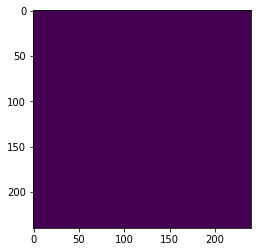

In [28]:
plt.imshow(x_fake[0, 75, :, :].detach().cpu())
plt.show

In [14]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

# Train the image generator

def train():
    # Training Loop
    iters = 0
    D_G_z_last = 0
    minimax_loss_last = 0
    
    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(cf.num_epochs):
        
        start_time = time()
        
        # For each batch in the dataloader
        for i, data in enumerate(trainloader):
            
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_image = data['image'].to(device, dtype=torch.float)
            real_mask = data['mask'].to(device, dtype=torch.float)
            real_cpu = torch.cat([real_image, real_mask], axis = 1)
            b_size = real_cpu.size(0)
            #label = torch.full((b_size,), real_label, device=device)
            label = (torch.ones(b_size, 1) * 0.9).to(device, dtype=torch.float)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()
            
            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, cf.nz, 240, 240, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Add the gradients from the all-real and all-fake batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()
            
            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake.detach()).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()
            
            
            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, cf.num_epochs, i, len(train_indices),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                
                # Save Losses for plotting later
                G_losses.append(errG.item())
                D_losses.append(errD.item())
                
                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 500 == 0) or ((epoch == cf.num_epochs-1) and (i == len(train_indices)-1)):
                    with torch.no_grad():
                        fake = netG(fixed_noise).detach().cpu()
                        img_list.append(make_grid(fake, padding=2, normalize=True))
                        iters += 1
        
        time_taken = time() - start_time
        print('Epoch ', str(epoch), ': training time: ', str(time_taken), 's')
        
        # Save the best model (determined by minimax loss) and give it a unique name.
        best_G_path = os.path.join(gan_save_path, 'Generator_best_model.pth')
        best_D_path = os.path.join(gan_save_path, 'Discriminator_best_model.pth')
        minimax_loss = np.log(D_x) + np.log(1 - D_G_z2)
        if  D_G_z_last < D_G_z2:
            torch.save(netG.state_dict(), best_G_path)
            D_G_z_last = D_G_z2
            print(f'\tBest generator saved at D(G(z)): {D_G_z2:.5f}')
        else:
            print()
        if  minimax_loss_last < minimax_loss:
            torch.save(netD.state_dict(), best_D_path)
            minimax_loss_last = minimax_loss
            print(f'\tBest discriminator saved at minimax loss: {minimax_loss:.5f}')
        else:
            print()
            
        final_G_path = os.path.join(gan_save_path, 'Generator_final_model.pth')
        torch.save(netG.state_dict(), final_G_path)
        final_D_path = os.path.join(gan_save_path, 'Discriminator_final_model.pth')
        torch.save(netD.state_dict(), final_D_path) 
            
    final_G_path = os.path.join(gan_save_path, 'Generator_final_model.pth')
    torch.save(netG.state_dict(), final_G_path)
    final_D_path = os.path.join(gan_save_path, 'Discriminator_final_model.pth')
    torch.save(netD.state_dict(), final_D_path)                                        

train()

Starting Training Loop...
[0/70][0/269]	Loss_D: 1.9311	Loss_G: 40.0297	D(x): 0.3431	D(G(z)): 0.5484 / 0.0000
Epoch  0 : training time:  259.77771162986755 s
	Best generator saved at D(G(z)): 0.00000

[1/70][0/269]	Loss_D: 0.7906	Loss_G: 68.4631	D(x): 0.8575	D(G(z)): 0.0000 / 0.0000
Epoch  1 : training time:  261.446720123291 s
	Best generator saved at D(G(z)): 0.00000

[2/70][0/269]	Loss_D: 1.9139	Loss_G: 22.5082	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
Epoch  2 : training time:  264.63347482681274 s


[3/70][0/269]	Loss_D: 1.0012	Loss_G: 22.1742	D(x): 0.6088	D(G(z)): 0.0000 / 0.0000
Epoch  3 : training time:  266.33409547805786 s


[4/70][0/269]	Loss_D: 1.7750	Loss_G: 27.6310	D(x): 0.4439	D(G(z)): 0.0000 / 0.0000
Epoch  4 : training time:  264.6179668903351 s


[5/70][0/269]	Loss_D: 2.3638	Loss_G: 27.6310	D(x): 0.9941	D(G(z)): 0.0000 / 0.0000
Epoch  5 : training time:  264.4708330631256 s


[6/70][0/269]	Loss_D: 1.9839	Loss_G: 63.4843	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
Epoch  6 : trai

KeyboardInterrupt: 

In [15]:
final_G_path = os.path.join(gan_save_path, 'Generator_final_model.pth')
torch.save(netG.state_dict(), final_G_path)
final_D_path = os.path.join(gan_save_path, 'Discriminator_final_model.pth')
torch.save(netD.state_dict(), final_D_path)         

In [25]:
vz.lossvstrain(G_losses, D_losses)
vz.generatorprogress(img_list)
vz.realvfake(device, img_list)

AttributeError: module 'visualize' has no attribute 'lossvstrain'

## 3. Train a U-Net with original data + GAN augmented data

In [9]:
def dice_coefficient(predicted, target):
    '''
    Calculates the Sørensen–Dice Coefficient for a single sample.
    Parameters:
        predicted(numpy.ndarray): Predicted single output of the network.
                                Shape - (Channel, Height, Width)
        target(numpy.ndarray): Actual required single output for the network
                                Shape - (Channel, Height, Width)

    Returns:
        coefficient(float): Dice coefficient for the input sample.
                                    1 represents highest similarity and
                                    0 represents lowest similarity.
    '''
    # The smooth term is used to prevent division by zero.
    smooth = 1
    product = np.multiply(predicted, target)
    intersection = np.sum(product)
    coefficient = (2 * intersection + smooth) / (np.sum(predicted) + np.sum(target) + smooth)
    return coefficient

In [10]:
unet_classifier = None
criterion = nn.BCELoss()
learning_rate = 0.0001

#### If you want to see the training trend within each epoch, you can change mini_batch to a positive integer 
#### that is no larger than the number of batches per epoch.
mini_batch = False

# Define where to save the model parameters.
model_save_path = './baseline&gan_saved_models/'
os.makedirs(model_save_path, exist_ok = True)

# New model is created.
unet_model = U_Net().to(device)
state_dict = torch.load(os.path.join(model_save_path, 'Basic_Unet_best_model.pth'))
unet_model.load_state_dict(state_dict)

#### You can uncomment this to see the textual architecture of our U-Net.
#print(unet_model)

<All keys matched successfully>

In [ ]:
# Training session history data.
history = {'train_loss': list(), 'validation_loss': list()}

# For save best feature. Initial loss taken a very high value.
last_score = 0

# Optimizer used for training process. Adam Optimizer.
optimizer = optim.Adam(unet_model.parameters(), lr = learning_rate)

# Reducing LR on plateau feature to improve training.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.85, patience = 2, verbose = True)

print('Starting Training Process')

assert validationloader.batch_size == 1

# Epoch Loop
for epoch in range(epochs):
    
    #################################### Train ####################################################
    unet_model.train()
    start_time = time()
    # Training a single epoch
    train_epoch_loss, train_batch_loss, batch_iteration = 0, 0, 0
    validation_score, validation_loss = 0, 0

    for batch, data in enumerate(trainloader):
        # Keeping track how many iteration is happening.
        batch_iteration += 1
        # Loading data to device used.
        image = data['image'].to(device, dtype=torch.float)
        mask = data['mask'].to(device, dtype=torch.float)
        # Clearing gradients of optimizer.
        optimizer.zero_grad()
        # Calculation predicted output using forward pass.
        output = unet_model(image)
        # Calculating the loss value.
        loss_value = criterion(output, mask)
        # Computing the gradients.
        loss_value.backward()
        # Optimizing the network parameters.
        optimizer.step()
        # Updating the running training loss
        train_epoch_loss += loss_value.item()
        train_batch_loss += loss_value.item()

        # Printing batch logs if any. Useful if you want to see the training trends within each epoch.
        if mini_batch:
            if (batch + 1) % mini_batch == 0:
                train_batch_loss = train_batch_loss / (mini_batch * trainloader.batch_size)
                print(
                    f'    Batch: {batch + 1:2d},\tBatch Loss: {train_batch_loss:.7f}')
                train_batch_loss = 0

    train_epoch_loss = train_epoch_loss / (batch_iteration * trainloader.batch_size)
    
    ################################### Validation ##################################################
    unet_model.eval()
    # To get data in loops.
    batch_iteration = 0

    for batch, data in enumerate(validationloader):
        # Keeping track how many iteration is happening.
        batch_iteration += 1
        # Data prepared to be given as input to model.
        image = data['image'].to(device, dtype=torch.float)
        mask = data['mask'].to(device, dtype=torch.float)

        # Predicted output from the input sample.
        mask_prediction = unet_model(image)
        
        # comput validation loss
        loss_value = criterion(mask_prediction, mask)
        validation_loss += loss_value.item()
        
        # Threshold elimination.
        mask_prediction = (mask_prediction > 0.5)
        mask_prediction = mask_prediction.cpu().numpy()
        mask = mask.cpu().numpy()

        mask = np.resize(mask, (155, 240, 240))
        mask_prediction = np.resize(mask_prediction, (155, 240, 240))
        # Calculate the dice score for original and predicted image mask.
        validation_score += dice_coefficient(mask_prediction, mask)

    # Calculating the mean score for the whole validation dataset.
    unet_val = validation_score / batch_iteration
    validation_loss = validation_loss / batch_iteration
    
    # Collecting all epoch loss values for future visualization.
    history['train_loss'].append(train_epoch_loss)
    history['validation_loss'].append(validation_loss)
    
    # Reduce LR On Plateau
    scheduler.step(validation_loss)

    time_taken = time() - start_time
    
    # Training Logs printed.
    print(f'Epoch: {epoch + 1:3d},  ', end = '')
    print(f'train Loss: {train_epoch_loss:.5f},  ', end = '')
    print(f'validation Loss: {validation_loss:.5f},  ', end = '')
    print(f'validation score: {unet_val:.5f},  ', end = '')

    for pg in optimizer.param_groups:
        print('current lr: ', pg['lr'], ', ', end = '')
    print(f'Time: {time_taken:.2f} s', end = '')

    # Save the model every epoch.
    #current_epoch_model_save_path = os.path.join(model_save_path, 'Basic_Unet_epoch_%s.pth' % (str(epoch).zfill(3)))
    #torch.save(unet_model.state_dict(), current_epoch_model_save_path)
    
    # Save the best model (determined by validation score) and give it a unique name.
    best_model_path = os.path.join(model_save_path, 'Basic_Unet_best_model.pth')
    if  last_score < unet_val:
        torch.save(unet_model.state_dict(), best_model_path)
        last_score = unet_val
        print(f'\tBest model saved at score: {unet_val:.5f}')
    else:
        print()

print(f'Training Finished after {epochs} epoches')

Starting Training Process
Epoch:   1,  train Loss: -0.01371,  validation Loss: -0.00461,  validation score: 0.50238,  current lr:  0.0001 , Time: 467.84 s	Best model saved at score: 0.50238
Epoch:   2,  train Loss: -0.01853,  validation Loss: -0.00592,  validation score: 0.56722,  current lr:  0.0001 , Time: 364.87 s	Best model saved at score: 0.56722
Epoch:   3,  train Loss: -0.02031,  validation Loss: -0.00511,  validation score: 0.66926,  current lr:  0.0001 , Time: 363.35 s	Best model saved at score: 0.66926
Epoch:   4,  train Loss: -0.02165,  validation Loss: -0.01393,  validation score: 0.67431,  current lr:  0.0001 , Time: 362.80 s	Best model saved at score: 0.67431
Epoch:   5,  train Loss: -0.02188,  validation Loss: -0.01145,  validation score: 0.58129,  current lr:  0.0001 , Time: 362.27 s
Epoch:   6,  train Loss: -0.02277,  validation Loss: -0.02350,  validation score: 0.65068,  current lr:  0.0001 , Time: 362.64 s
Epoch:   7,  train Loss: -0.02162,  validation Loss: -0.0213

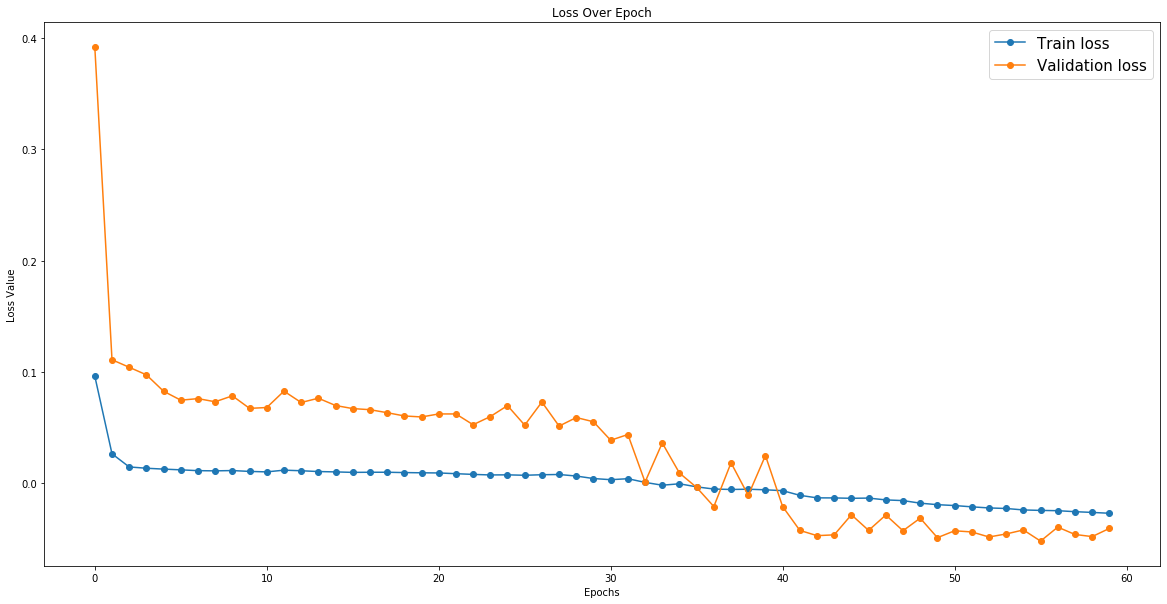

In [98]:
plt.figure(figsize=(20, 10))
plt.title('Loss Over Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
train_curve = plt.plot(history['train_loss'], marker = 'o', label = 'Train loss')
validation_curve = plt.plot(history['validation_loss'], marker = 'o', label = 'Validation loss')
plt.legend(fontsize = 15)
plt.show()

In [13]:
# Load the unet model at its prime (when it performed the best on the validation set).
state_dict = torch.load(os.path.join(model_save_path, 'Basic_Unet_best_model.pth'))
unet_model.load_state_dict(state_dict)

# Testing process on test data.
unet_model.eval()
# Getting test data indices for dataloading
test_data_indexes = test_indices
# Total testing data used.
data_length = len(test_data_indexes)
# Score after testing on dataset.
mean_test_score = 0

for batch, data in enumerate(testloader):
    # Data prepared to be given as input to model.
    image = data['image'].to(device, dtype=torch.float)
    mask = data['mask']

    # Predicted output from the input sample.
    mask_prediction = unet_model(image).cpu()
    # Threshold elimination.
    mask_prediction = (mask_prediction > 0.5)
    mask_prediction = mask_prediction.numpy()

    mask = np.resize(mask, (155, 240, 240))
    mask_prediction = np.resize(mask_prediction, (155, 240, 240))

    # Calculating the dice score for original and predicted mask.
    mean_test_score += dice_coefficient(mask_prediction, mask)

# Calculating the mean score for the whole test dataset.
unet_score = mean_test_score / data_length
# Putting the model back to training mode.
print(f'\nDice Score {unet_score}\n')

RuntimeError: CUDA out of memory. Tried to allocate 144.00 MiB (GPU 0; 11.17 GiB total capacity; 1.57 GiB already allocated; 13.44 MiB free; 1.58 GiB reserved in total by PyTorch)

In [12]:
def result(image, mask, output, title, transparency = 0.38, save_path = None):
    '''
    Plots a 2x3 plot with comparisons of output and original image.
    Works best with Jupyter Notebook/Lab.
    Parameters:
        image(numpy.ndarray): Array containing the original image of MRI scan.
        mask(numpy.ndarray): Array containing the original mask of tumor.
        output(numpy.ndarray): Model predicted mask from input image.
        title(str): Title of the plot to be used.
        transparency(float): Transparency level of mask on images.
                             Default: 0.38
        save_path(str): Saves the plot to the location specified.
                        Does nothing if None. 
                        Default: None
    Return:
        None
    '''

    fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(
        10, 8), gridspec_kw={'wspace': 0.025, 'hspace': 0.010})
    fig.suptitle(title, x=0.5, y=0.92, fontsize=20)

    axs[0][0].set_title("Original Mask", fontdict={'fontsize': 16})
    axs[0][0].imshow(mask, cmap='gray')
    axs[0][0].set_axis_off()

    axs[0][1].set_title("Predicted Mask", fontdict={'fontsize': 16})
    axs[0][1].imshow(output, cmap='gray')
    axs[0][1].set_axis_off()

    mask_diff = np.abs(mask ^ output)
    axs[0][2].set_title("Mask Difference", fontdict={'fontsize': 16})
    axs[0][2].imshow(mask_diff, cmap='gray')
    axs[0][2].set_axis_off()

    seg_output = mask*transparency
    seg_image = np.add(image, seg_output)/2
    axs[1][0].set_title("Original Segmentation", fontdict={'fontsize': 16})
    axs[1][0].imshow(seg_image, cmap='gray')
    axs[1][0].set_axis_off()
    
    seg_output = output*transparency
    seg_image = np.add(image, seg_output)/2
    axs[1][1].set_title("Predicted Segmentation", fontdict={'fontsize': 16})
    axs[1][1].imshow(seg_image, cmap='gray')
    axs[1][1].set_axis_off()

    axs[1][2].set_title("Original Input Image", fontdict={'fontsize': 16})
    axs[1][2].imshow(image, cmap='gray')
    axs[1][2].set_axis_off()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi = 90, bbox_inches = 'tight')

    plt.show()

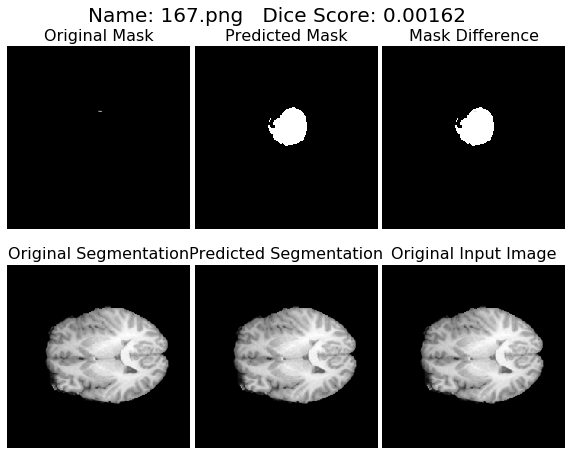

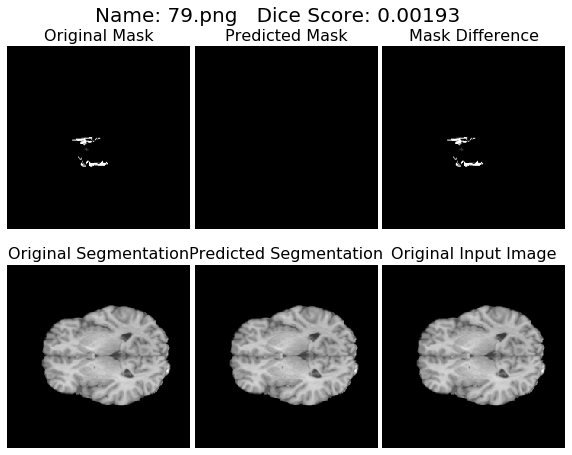

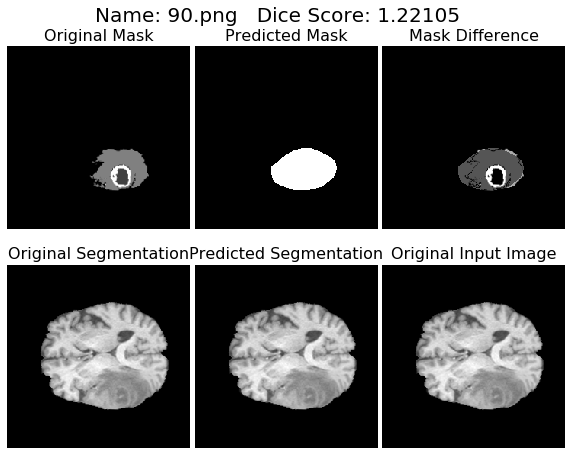

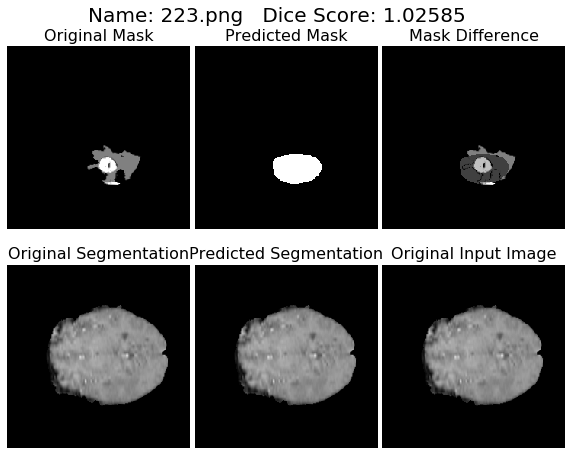

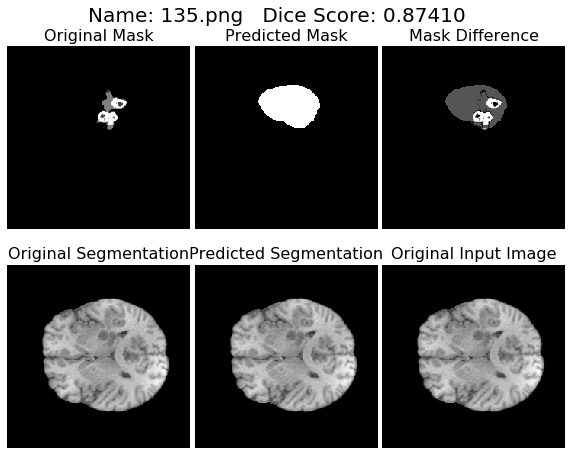

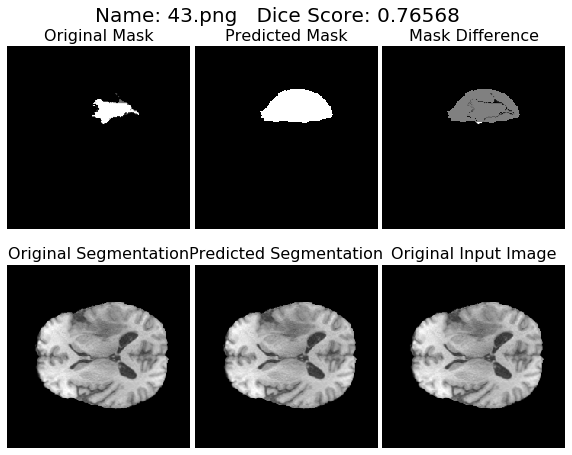

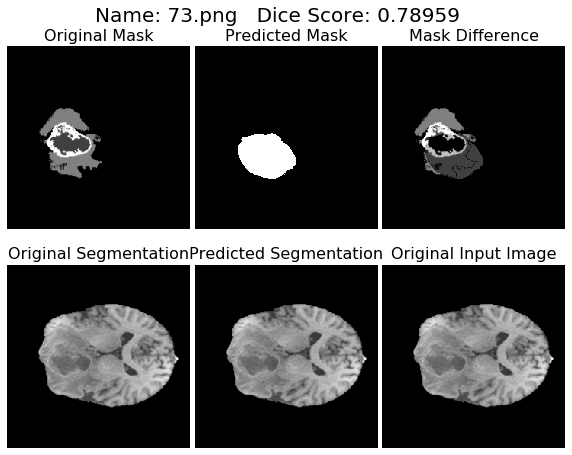

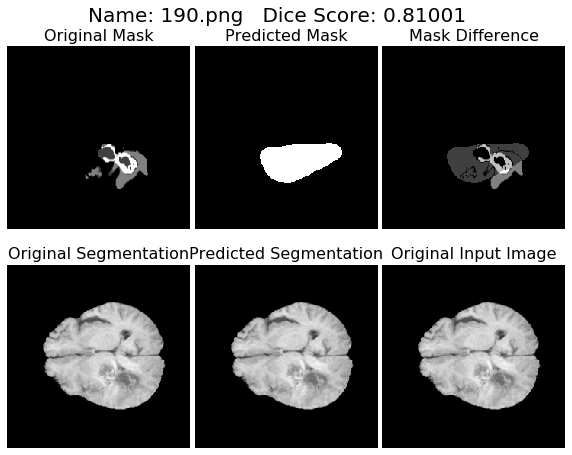

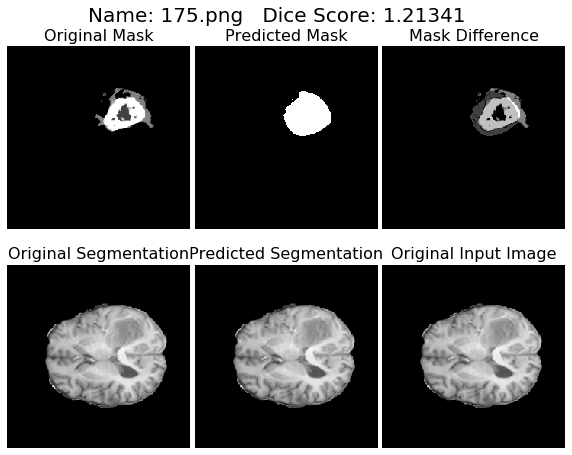

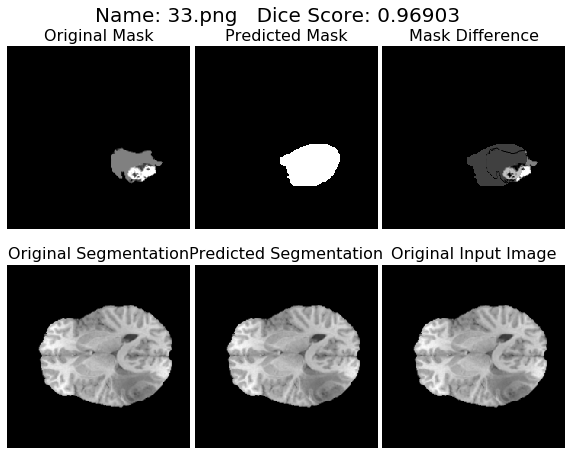

In [13]:
for example_index in range(10):
    # The purpose of image_index is to make sure we truly pick from the test set.
    image_index = test_indices[example_index]
    sample = tumor_dataset[image_index]
    threshold = 0.5

    unet_model.eval()
    image = sample['image'].numpy()
    mask = sample['mask'].numpy()

    image_tensor = torch.Tensor(image)
    image_tensor = image_tensor.view((-1, 155, 240, 240)).to(device)
    output = unet_model(image_tensor).detach().cpu()
    output = (output > threshold)
    output = output.numpy()


    image = np.resize(image, (155, 240, 240))
    image = image[70,:,:]
    mask = np.resize(mask, (155, 240, 240))
    mask = mask[70,:,:]
    output = np.resize(output, (155, 240, 240))
    output = output[70,:,:]
    # score(float): Sørensen–Dice Coefficient for mask and output. Calculates how similar are the two images.
    d_score = dice_coefficient(output, mask)

    title = f'Name: {image_index}.png   Dice Score: {d_score:.5f}'
    # save_path = os.path.join('images',f'{d_score:.5f}_{image_index}.png')
    result(image, mask, output, title, save_path = None)